# Multiomics Visualisation

For more information please contact [Tyrone Chen](mailto:tyrone.chen@monash.edu) or [Sonika Tyagi](mailto:sonika.tyagi@monash.edu).

## Table of contents
1. [Information for biologists](#biologists)
2. [Information for bioinformaticians](#bioinformaticians)
3. [Information for methods section](#methods)
4. [Plotting steps](#plotting)
5. *Work in progress* [Filtering data to be visualised](#filtering)
    - [Comparing multi-omics data per strain (pathways)](#omics_vs_strain)
    - [Comparing strain per multi-omics data (pathways)](#strain_vs_omics)
    - [Staphylococcus aureus enriched pathways](#staphylococcus_aureus)
    - [All species enriched pathways](#all_species)
6. [Supplementary data (reference only)](#supplementary_data)

## UpSetPlots

### Information for biologists <a name="biologists"></a>
UpSetPlots are a visualisation method which can be interpreted as a quantitative venn diagram. [More information on the method can be found in the original 2014 publication](https://rdcu.be/bO4oV), and a [sample interactive UpSetPlot on unrelated data is available here](https://vdl.sci.utah.edu/upset2/embed.html#{"NavBar":false,"FilterBox":false,"DataSetInfo":false,"LeftSideBar":true,"RightSideBar":false,"ProvenanceView":false,"DeviationBars":true,"CardinalityBars":true}).

### Information for bioinformaticians <a name="bioinformaticians"></a>
Implementations exist in [javascript](https://github.com/VCG/upset), [python](https://pypi.org/project/UpSetPlot/) and [R](https://github.com/hms-dbmi/UpSetR). For this `python` implementation the requirements is just `upsetplot` which can be installed with:

```
pip install upsetplot
```
or
```
conda install upsetplot -c conda-forge
```

While the following libraries are also required, they should get installed automatically when installing the UpSetPlot library through conda:
```
matplotlib
numpy
pandas
```
[OPTIONAL] If using a jupyter notebook in a `conda` or other virtual environment, the following library can be used to easily switch kernels:
```
nb_conda=2.2.1
```

### Information for methods section <a name="methods"></a>
*To be written as the final step of this report*

In [1]:
# The raw code for this IPython notebook is by default hidden for easier reading.
import warnings
warnings.filterwarnings('ignore')
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

We load the libraries we need:

In [2]:
import numpy
import pandas
from matplotlib import pyplot as plt
from upsetplot import from_contents, from_memberships, plot, generate_counts, UpSet
%matplotlib inline

Reformatting the input data is straightforward:
    1. Load input data as a pandas dataframe
    2. Filter the data and extract the required fields
    3. Reformat data to an input for upsetplot
    4. Make UpSetPlot
    
For the input data, we use information generated previously in the file `KEGG_Fisher_Exact_test_all_results.tsv`, `MD5 ec4faa14d08cf6f9ffc4631192127b3a`.

### Load input data as a pandas dataframe

At time of writing, the data does not contain the RNA-Seq data for *Escherichia coli MS14387*, *Streptococcus pyogenes 5448*, *HKU419*, *SP444*. These were aligned on 24/08/2019. Here is how the full dataset looks like:

In [3]:
infile_path = "KEGG_Fisher_Exact_test_all_results.tsv"
data = pandas.read_csv(infile_path, sep="\t")
data.head()

,Species,Strain,Type_of_Experiment,Comparisons,Direction,kegg_pathway_name,kegg_pathway_id,p_value_raw,odds_ratio,FDR,is_de_genes.TRUE|is_gene_set.TRUE,is_de_genes.TRUE|is_gene_set.FALSE,is_de_genes.FALSE|is_gene_set.TRUE,is_de_genes.FALSE|is_gene_set.FALSE,de_gene_with_annotation_list
0,Streptococcus pneumoniae,4496,RNA-Seq,Sera vs. RPMI + Galactose,Down,Pyrimidine metabolism,240,1.601326e-02,1.823092,1.000000e+00,24,446,46,1559,"WP_127820727.1, WP_000763053.1, WP_000120709.1..."
1,Streptococcus pneumoniae,4496,RNA-Seq,Sera vs. RPMI + Galactose,Down,Metabolic pathways,1100,6.745431e-09,1.901218,9.173787e-07,183,287,403,1202,"WP_000451584.1, WP_000176987.1, WP_000651213.1..."
2,Streptococcus pneumoniae,4496,RNA-Seq,Sera vs. RPMI + Galactose,Down,Cysteine and methionine metabolism,270,2.782556e-01,1.275864,1.000000e+00,13,457,35,1570,"WP_000331296.1, WP_000216382.1, WP_000167817.1..."
3,Streptococcus pneumoniae,4496,RNA-Seq,Sera vs. RPMI + Galactose,Down,Biosynthesis of secondary metabolites,1110,2.164623e-06,1.943849,2.900595e-04,95,375,185,1420,"WP_127820724.1, WP_127820744.1, WP_001216915.1..."
4,Streptococcus pneumoniae,4496,RNA-Seq,Sera vs. RPMI + Galactose,Down,Biosynthesis of amino acids,1230,6.001860e-04,1.940969,7.622362e-02,45,425,83,1522,"WP_001216915.1, WP_000191798.1, WP_127820776.1..."


We take a look at some properties of the data:

In [4]:
print("".join(["Data dimensions: ", str(data.shape)]))
print("".join(["Quantity of assay types: ", str(len(data.Type_of_Experiment.unique()))]))
print("".join(["Quantity of KEGG pathways: ", str(len(data.kegg_pathway_name.unique()))]))

Data dimensions: (31812, 15)
Quantity of assay types: 5
Quantity of KEGG pathways: 283


Filter data based on criteria of interest. In this case we remove everything that falls under a false discovery rate threhsold of 0.05.

In [5]:
# load data
infile_path = "KEGG_Fisher_Exact_test_all_results.tsv"
data = pandas.read_csv(infile_path, sep="\t")
data["Species_Strain_Type_of_Experiment"] = data["Species"] + " " + data["Strain"] + " " + data["Type_of_Experiment"]
data["Species_Strain"] = data["Species"] + " " + data["Strain"]
data["Species_Strain_Type_of_Experiment_Direction"] = data["Species"] + " " + data["Strain"] + " " + data["Type_of_Experiment"] + " " + data["Direction"]
data["Type_of_Experiment_Direction"] = data["Type_of_Experiment"] + " " + data["Direction"]
all_sp_strains = data["Species"] + " " + data["Strain"]
all_sp_strains_unique = all_sp_strains.unique()

# we want to filter out pathways of interest
# filter out the data points of interest
filter_unit = "FDR"
threshold = 0.05

superset = data.loc[data[filter_unit] > threshold]
subset = data.loc[data[filter_unit] < threshold]
subset_sp_strains = subset["Species"] + " " + subset["Strain"]
subset_sp_strains_unique = subset_sp_strains.unique()
#subset.reset_index(inplace=True)
intermediate_data = subset

removed = set(all_sp_strains_unique) - set(subset_sp_strains_unique)
if removed:
    removed = str(removed)
else:
    removed = "None"

print(" ".join(["Data dimensions before", str(filter_unit), str(threshold), "filter:", str(data.shape)]))
print(" ".join(["Data dimensions after", str(filter_unit), str(threshold), "filter: ", str(subset.shape)]))
print(" ".join(["Strains removed by", str(filter_unit), str(threshold), "filter:", removed]))

Data dimensions before FDR 0.05 filter: (31812, 19)
Data dimensions after FDR 0.05 filter:  (974, 19)
Strains removed by FDR 0.05 filter: {'Escherichia coli MS14387'}


In [6]:
# some helper functions are defined here to automate repetitive tasks
def reformat_data_for_upsetplot(data, column):
    """
    Take a dataframes to be plotted, desired categories, return labelled list of reformatted dataframes
    """
    omics_kegg = data
    omics = omics_kegg[column].unique()
    omics.sort()
    omics_kegg = [omics_kegg[omics_kegg[column].str.contains(omic)] for omic in omics]
    collapse_kegg = lambda x: "|".join(x).split("|")
    omics_kegg = [omic_kegg.groupby(omic_kegg['Species_Strain']).aggregate({'kegg_pathway_name':collapse_kegg}) for omic_kegg in omics_kegg]
    before = [omic.shape[0] for omic in omics_kegg]
    omics_kegg = [omic_kegg.loc[omic_kegg.astype(str).drop_duplicates().index] for omic_kegg in omics_kegg]
    after = [omic.shape[0] for omic in omics_kegg]
    duplicates_dropped = [i - j for i, j in zip(before, after)]
    duplicates_per_exp = list(zip(omics, duplicates_dropped))

    # removes pathways duplicated within a single strain
    temp = list()
    for omic in omics_kegg:
        omic["kegg_pathway_name"] = omic["kegg_pathway_name"].apply(set).apply(list).apply(sorted)
        temp.append(omic)
    omics_kegg = temp
    [print(omic, "as one plot") for omic in omics]

    # display non-overlapping strains
    sp_strains = data["Species"] + " " + data["Strain"]
    sp_strains_unique = sp_strains.unique()
    sp_strains_unique.sort()
    dropped_strains = [list(x) for x in [set(sp_strains_unique) - set(index) for index in [omic.index for omic in omics_kegg]]]
    dropped_strains = list(zip(omics, dropped_strains))
    [print("\nStrains dropped from", omic, "data as they had no KEGG pathway overlap:\n", pandas.DataFrame(strain)) for omic, strain in dropped_strains]
    return list(zip(omics, omics_kegg))

def make_upsetplot(data):
    """
    Take list of label, dataframe, plot upsetplots
    """
    for plt_title, strain_multiomic in data:
        # legends too long and run off page, shorten
        strain_multiomic.reset_index(inplace=True)
        old_index = strain_multiomic["Species_Strain"].tolist()
        assert len(set([plt_title])) is 1, "There seems to be more than one species present within one comparison"

        # shorten items to prevent legends going off page
        shortened = [
            ("Escherichia coli", "E. coli"), 
            ("Klebsiella pneumoniae", "K. pneu"),
            ("Klebsiella variicola", "K. var"), 
            ("Staphylococcus aureus", "S. aur"), 
            ("Streptococcus pneumoniae", "S. pneu"),
            ("Streptococcus pyogenes", "S. pyo")
        ] 
        new_index = list()    
        for omic in old_index:
            for long, short in shortened:
                omic = omic.replace(long, short)
            new_index.append(omic)

        strain_multiomic["Species_Strain"] = new_index
        strain_multiomic.set_index("Species_Strain", inplace=True)

        # reformat data to UpSetPlot format
        strain_multiomic = strain_multiomic.to_dict()['kegg_pathway_name']
        strain_multiomic = from_contents(strain_multiomic)
        upset = UpSet(strain_multiomic, subset_size='count', element_size=50)#, intersection_plot_elements=3)
        upset.plot()
        plt.title(" ".join([plt_title, "KEGG pathways"]))
        plt.show()

### *WORK IN PROGRESS* Comparing strain per multi-omics data (pathways) <a name="strain_vs_omics"></a>

Now we compare the strains (as rows in the Upset plot), with one plot per type of omics experiment. This way we can start finding pathways that are common across strains. [Procedure similar to comparing multi-omics data per strain](#omics_vs_strain). So we will end up with one plot per omics data, and many strains (rows). Strains which are dropped due to lack of overlap are listed.

In [7]:
# collapse across GC-MS and LC-MS
subset = intermediate_data
omics_kegg = subset.loc[ : , ['Species_Strain', 'Species_Strain_Type_of_Experiment', 'kegg_pathway_name', 'Species', 'Strain', 'Type_of_Experiment', 'Direction', 'Type_of_Experiment_Direction'] ]
omics_kegg.drop_duplicates(inplace=True)
before = omics_kegg.shape

# metabolomics block, also split into subsets based on regulation state (up or down)
metabolomics = omics_kegg[omics_kegg.Type_of_Experiment.str.startswith("Metabolomics")]
metabolomics["Type_of_Experiment"] = "Metabolomics"
metabolomics["Type_of_Experiment_Direction"] = metabolomics["Type_of_Experiment"] + " " + metabolomics["Direction"]
metabolomics_up = metabolomics[metabolomics["Direction"] == "Down"]
metabolomics_dn = metabolomics[metabolomics["Direction"] == "Up"]
assert (metabolomics.shape[0]) == (metabolomics_up.shape[0] + metabolomics_dn.shape[0]), "Total pathways surveyed should be the same"

# proteomics block, also split into subsets based on regulation state (up or down)
proteomics = omics_kegg[omics_kegg.Type_of_Experiment.str.startswith("Proteomics")]
proteomics["Type_of_Experiment"] = "Proteomics"
proteomics["Type_of_Experiment_Direction"] = proteomics["Type_of_Experiment"] + " " + proteomics["Direction"]
proteomics_up = proteomics[proteomics["Direction"] == "Down"]
proteomics_dn = proteomics[proteomics["Direction"] == "Up"]
assert (proteomics.shape[0]) == (proteomics_up.shape[0] + proteomics_dn.shape[0]), "Total pathways surveyed should be the same"

# rnaseq block, also split into subsets based on regulation state (up or down)
rna_seq = omics_kegg[omics_kegg.Type_of_Experiment.str.startswith("RNA-Seq")]
rna_seq["Type_of_Experiment"] = "RNA-Seq"
rna_seq["Type_of_Experiment_Direction"] = rna_seq["Type_of_Experiment"] + " " + rna_seq["Direction"]
rna_seq_up = rna_seq[rna_seq["Direction"] == "Down"]
rna_seq_dn = rna_seq[rna_seq["Direction"] == "Up"]
assert (rna_seq.shape[0]) == (rna_seq_up.shape[0] + rna_seq_dn.shape[0]), "Total pathways surveyed should be the same"

omics_kegg = pandas.concat([rna_seq, metabolomics, proteomics], verify_integrity=True, sort=True)
omics_kegg_direction = pandas.concat([rna_seq_up, rna_seq_dn, metabolomics_up, metabolomics_dn, proteomics_up, proteomics_dn], verify_integrity=True, sort=True)

assert before == omics_kegg.shape
assert before == omics_kegg_direction.shape, "Original and recombined data must have identical dimensions!"
omics_kegg.drop_duplicates(inplace=True)
omics_kegg_direction.drop_duplicates(inplace=True)

Omics data (Metabolomics, Proteomics and Transcriptomics) is further subsetted into *Upregulated* and *Downregulated* components.

Metabolomics Down as one plot
Metabolomics Up as one plot
Proteomics Down as one plot
Proteomics Up as one plot
RNA-Seq Down as one plot
RNA-Seq Up as one plot

Strains dropped from Metabolomics Down data as they had no KEGG pathway overlap:
                                     0
0        Streptococcus pyogenes PS003
1         Klebsiella pneumoniae AJ218
2            Escherichia coli MS14386
3       Staphylococcus aureus BPH2819
4       Staphylococcus aureus BPH2986
5       Staphylococcus aureus BPH2760
6       Streptococcus pneumoniae 4496
7      Streptococcus pneumoniae 180/2
8        Streptococcus pyogenes SP444
9                Escherichia coli B36
10         Klebsiella pneumoniae KPC2
11      Staphylococcus aureus BPH2900
12    Streptococcus pneumoniae 180/15
13        Streptococcus pyogenes 5448
14         Klebsiella variicola AJ292
15       Streptococcus pneumoniae 947
16  Klebsiella variicola 04153260899A
17      Staphylococcus aureus BPH2947
18      Streptococcus pyogenes HKU4

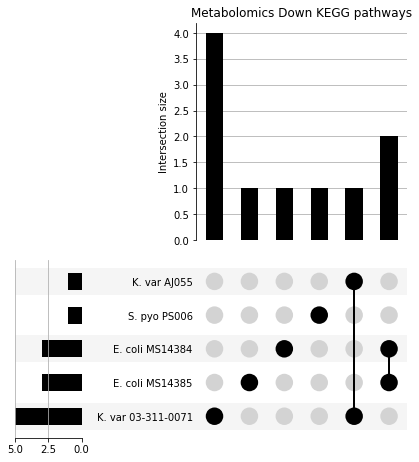

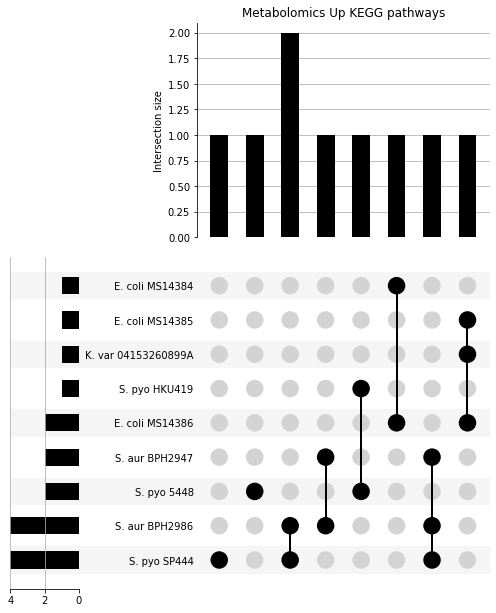

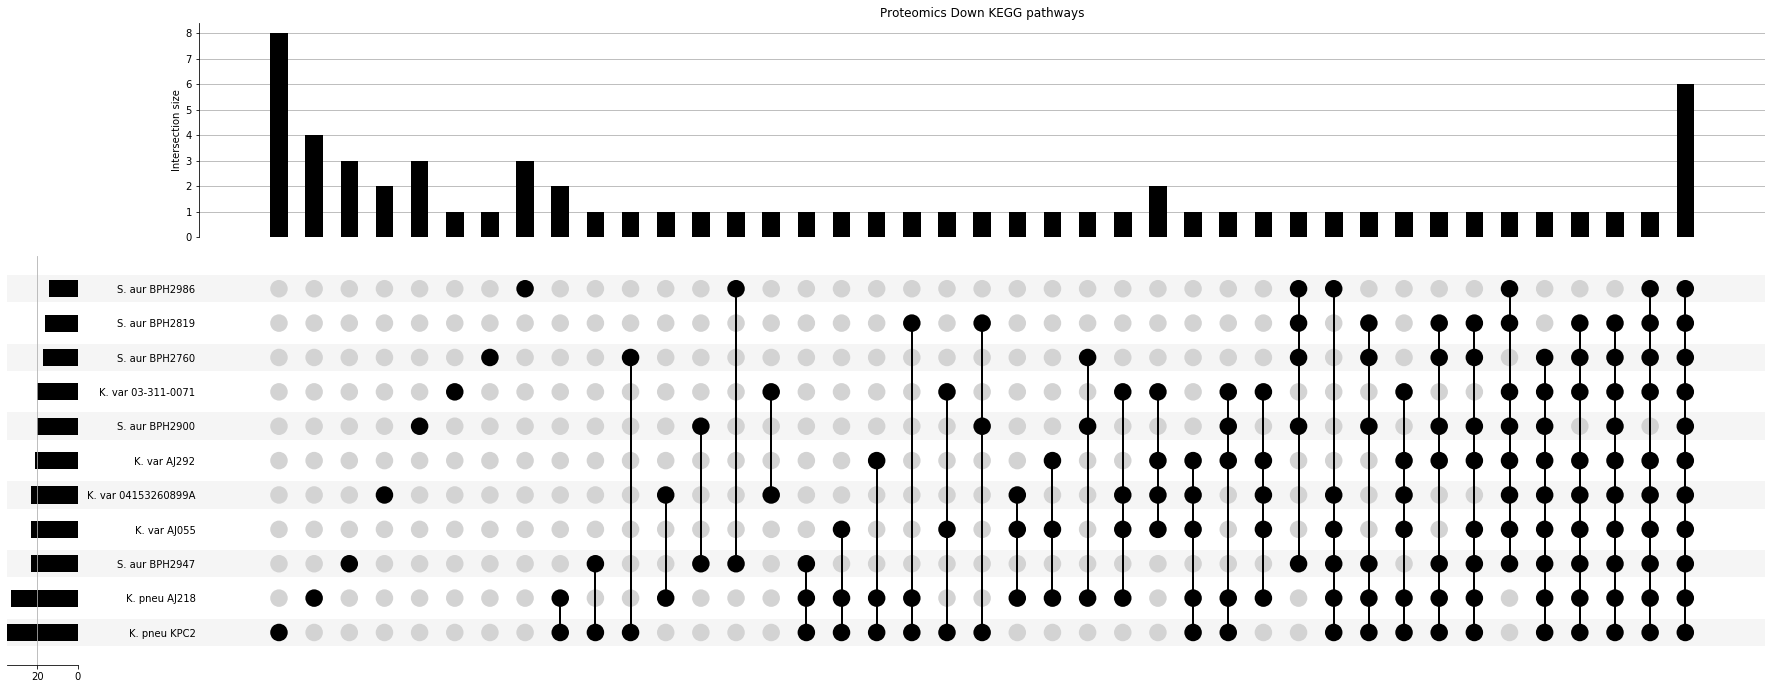

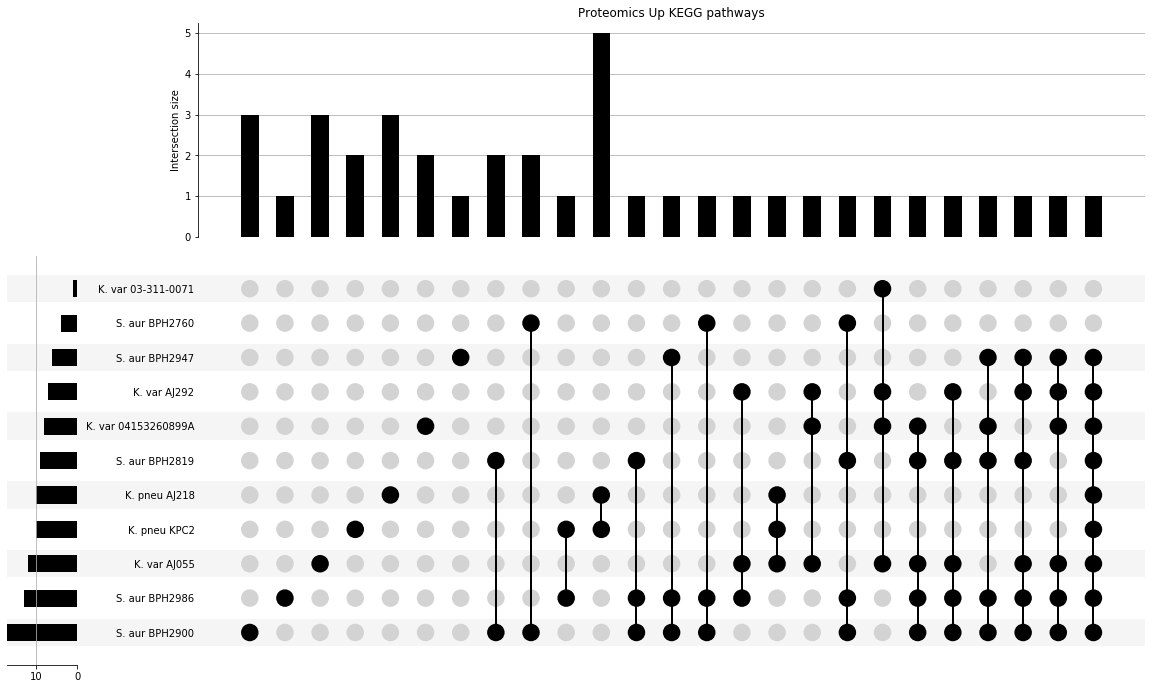

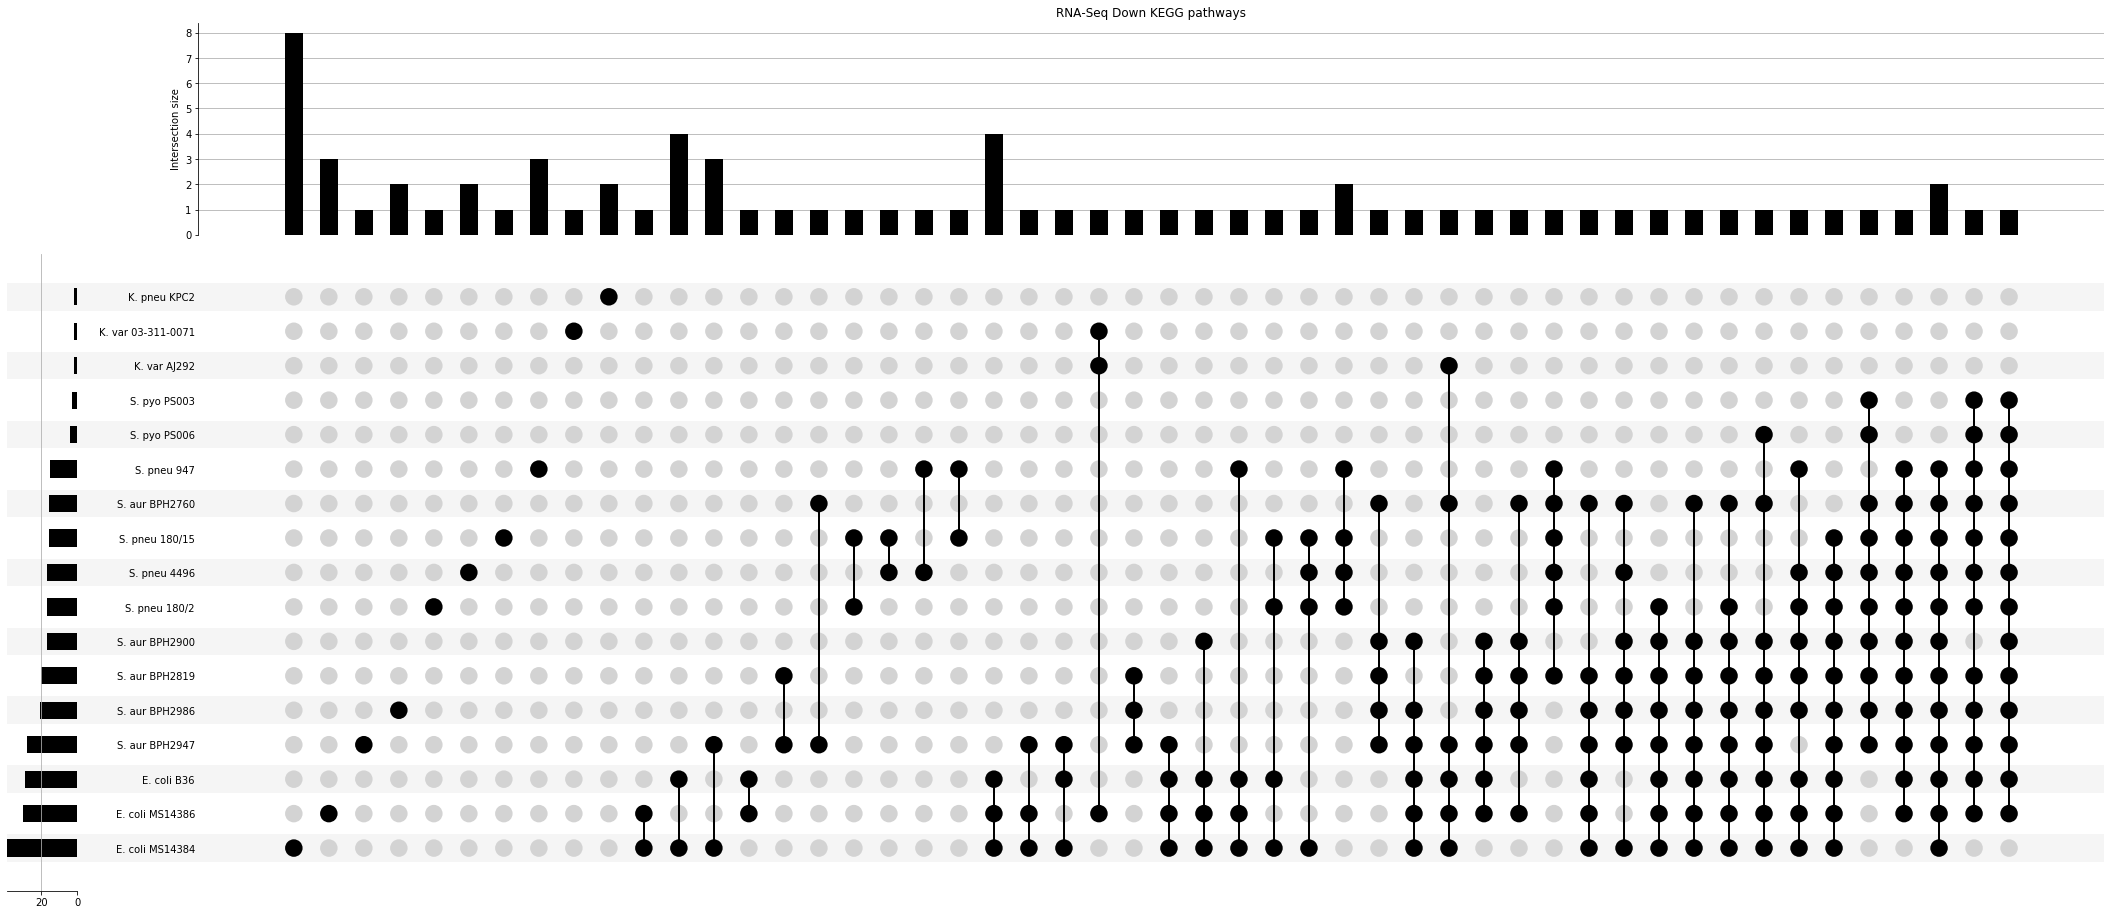

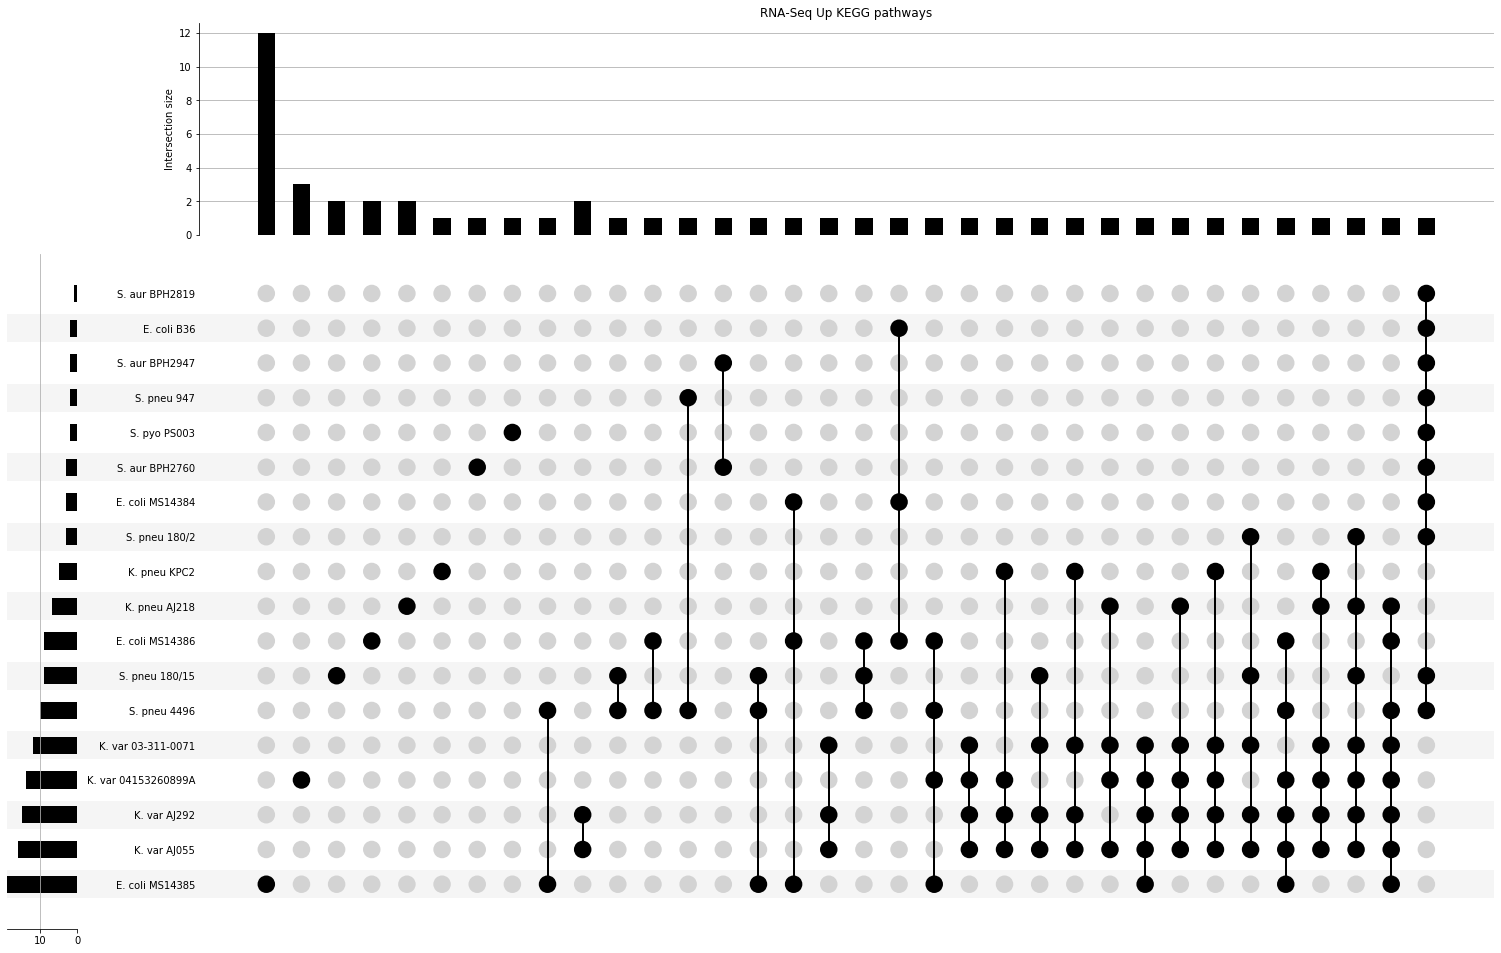

In [8]:
reformatted_omics_kegg_direction = reformat_data_for_upsetplot(omics_kegg_direction, "Type_of_Experiment_Direction")
make_upsetplot(reformatted_omics_kegg_direction)

## Staphylococcus aureus enriched pathways <a name="staphylococcus_aureus"></a>
We focus on *Staphylococcus aureus* because we have all the strains and omics data. 

We view the data from an **omics** perspective (eg instead of Metabolomics Down, Up we just have Metabolomics).

Metabolomics as one plot
Proteomics as one plot
RNA-Seq as one plot

Strains dropped from Metabolomics data as they had no KEGG pathway overlap:
                                0
0  Staphylococcus aureus BPH2760
1  Staphylococcus aureus BPH2900

Strains dropped from Proteomics data as they had no KEGG pathway overlap:
 Empty DataFrame
Columns: []
Index: []

Strains dropped from RNA-Seq data as they had no KEGG pathway overlap:
 Empty DataFrame
Columns: []
Index: []


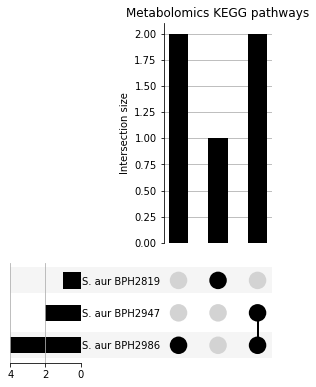

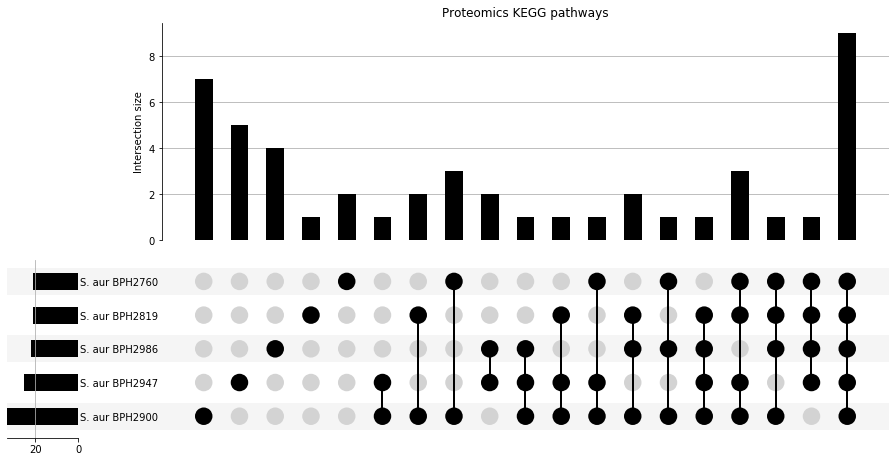

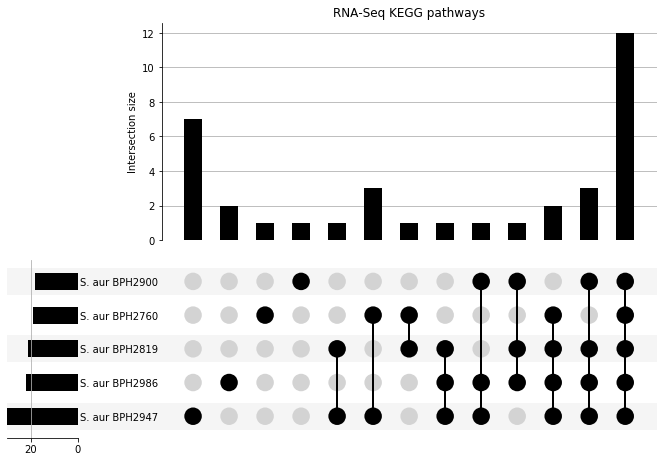

In [9]:
s_aureus = reformat_data_for_upsetplot(omics_kegg[omics_kegg["Species"] == "Staphylococcus aureus"], "Type_of_Experiment")
make_upsetplot(s_aureus)

 We also view the data from an **omics regulatory state** perspective.

Metabolomics Up as one plot
Proteomics Down as one plot
Proteomics Up as one plot
RNA-Seq Down as one plot
RNA-Seq Up as one plot

Strains dropped from Metabolomics Up data as they had no KEGG pathway overlap:
                                0
0  Staphylococcus aureus BPH2760
1  Staphylococcus aureus BPH2900

Strains dropped from Proteomics Down data as they had no KEGG pathway overlap:
 Empty DataFrame
Columns: []
Index: []

Strains dropped from Proteomics Up data as they had no KEGG pathway overlap:
 Empty DataFrame
Columns: []
Index: []

Strains dropped from RNA-Seq Down data as they had no KEGG pathway overlap:
 Empty DataFrame
Columns: []
Index: []

Strains dropped from RNA-Seq Up data as they had no KEGG pathway overlap:
                                0
0  Staphylococcus aureus BPH2986
1  Staphylococcus aureus BPH2900


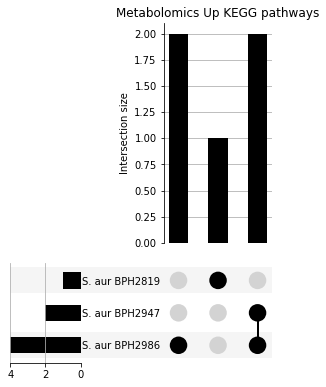

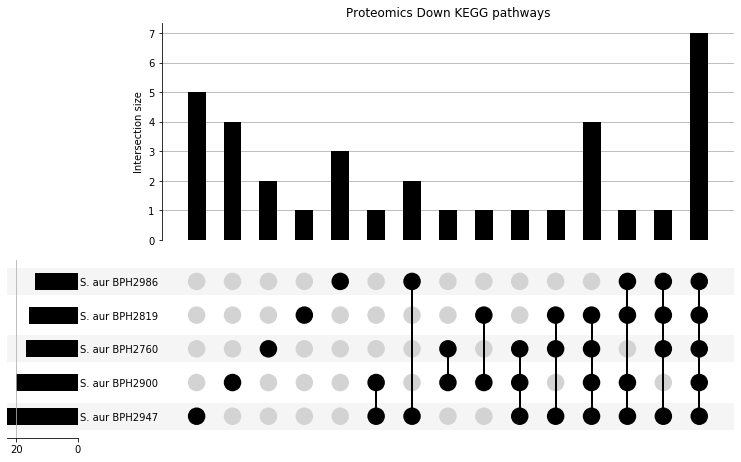

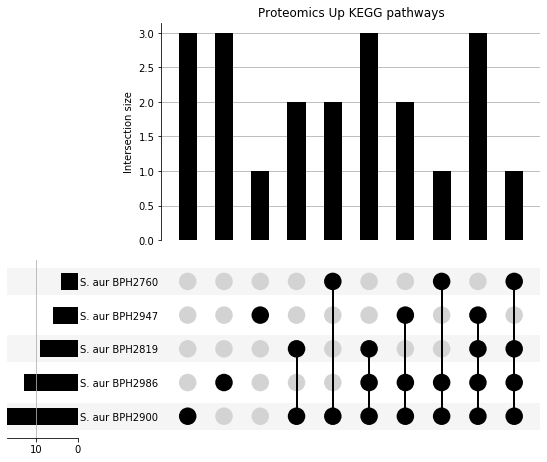

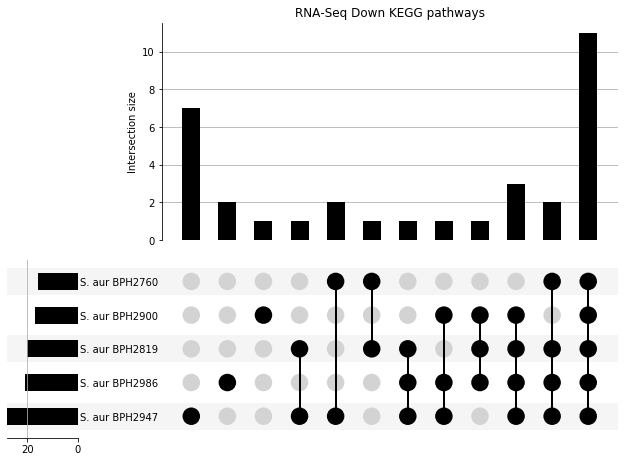

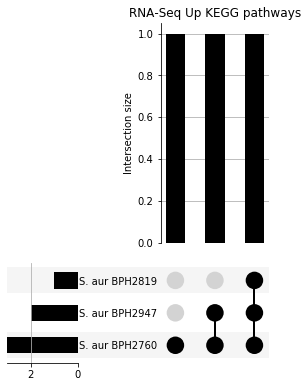

In [10]:
s_aureus_direction = reformat_data_for_upsetplot(omics_kegg_direction[omics_kegg_direction["Species"] == "Staphylococcus aureus"], "Type_of_Experiment_Direction")
make_upsetplot(s_aureus_direction)

For ***Staphylococcus aureus***, we need to list the pathways found to be enriched in the most number of strains (top 0.95 percentile of intersections). This will be performed for each type of experiment (omics) as above. Its top pathways will be extracted and presented in a few different ways.

The next section will show this information for **all bacterial strains**.

In [11]:
# helper function to automate extraction of desired quantile values
def extract_pathway_by_intersections(data, quantile=0.95):
    """
    Take dataframe, filtering criteria, and return pathways of interest
    """
    data = from_contents(data.to_dict()["kegg_pathway_name"]).reset_index().set_index(["id"]).astype(int)
    data["intersections_count"] = data.sum(axis=1)
    assert type(quantile) is float or type(quantile) is int, "Please input a value in the range of [0,1]"
    data = data[data["intersections_count"] >= data["intersections_count"].quantile(quantile)]
    data = pandas.DataFrame(data["intersections_count"]).reset_index()
    data.columns.values[0] = "pathway_id_KEGG"
    return data.set_index("pathway_id_KEGG")

quantile = 0.95
most_intersections_omics = list()
most_intersections_omics_direction = list()
for name, path in s_aureus:
    most_intersections_omics.append((name, extract_pathway_by_intersections(path, quantile)))
for name, path in s_aureus_direction:
    most_intersections_omics.append((name, extract_pathway_by_intersections(path, quantile)))
    
# export tsv files of pathways:quantity of intersections across strains
for name, path in most_intersections_omics:
    print("S aureus", name, "= quantile", quantile ,"and above of pathways which overlap across strains:\n", path["intersections_count"], "\n")
    path.to_csv("_".join(["S_aureus", "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")
for name, path in most_intersections_omics_direction:
    print("S aureus", name, "= quantile", quantile ,"and above of pathways which overlap across strains:\n", path["intersections_count"], "\n")
    path.to_csv("_".join(["S_aureus", "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")

S aureus Metabolomics = quantile 0.95 and above of pathways which overlap across strains:
 pathway_id_KEGG
Glucosinolate biosynthesis                    2
Valine, leucine and isoleucine degradation    2
Name: intersections_count, dtype: int64 

S aureus Proteomics = quantile 0.95 and above of pathways which overlap across strains:
 pathway_id_KEGG
Biosynthesis of antibiotics                     5
Biosynthesis of secondary metabolites           5
Carbon metabolism                               5
Citrate cycle (TCA cycle)                       5
Glyoxylate and dicarboxylate metabolism         5
Metabolic pathways                              5
Microbial metabolism in diverse environments    5
Purine metabolism                               5
Pyruvate metabolism                             5
Name: intersections_count, dtype: int64 

S aureus RNA-Seq = quantile 0.95 and above of pathways which overlap across strains:
 pathway_id_KEGG
Biosynthesis of antibiotics                     5
Carbon

## All species enriched pathways <a name="all_species"></a>
Here we show the biochemical pathways which have the most intersections (top 0.95 percentile) across **all bacterial species** within a single comparison: 

- Metabolomics Downregulated
- Metabolomics Upregulated 
- Proteomics Downregulated
- Proteomics Upregulated
- RNA-Seq Downregulated
- RNA-Seq Upregulated


In [12]:
quantile = 0.95
most_intersections = list()
for name, path in reformatted_omics_kegg_direction:
    most_intersections.append((name, extract_pathway_by_intersections(path, quantile)))

# export tsv files of pathways:quantity of intersections across strains
for name, path in most_intersections:
    print(name, "= quantile", quantile ,"of pathways which overlap across strains:\n", path["intersections_count"], "\n")
    path.to_csv("_".join(["All_species", "_".join(name.split(" ")), "quantile", str(quantile), "and_above.csv"]), sep="\t")

Metabolomics Down = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Alanine, aspartate and glutamate metabolism    2
Two-component system                           2
Streptomycin biosynthesis                      2
Name: intersections_count, dtype: int64 

Metabolomics Up = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Fatty acid biosynthesis       3
Glucosinolate biosynthesis    3
Name: intersections_count, dtype: int64 

Proteomics Down = quantile 0.95 of pathways which overlap across strains:
 pathway_id_KEGG
Biosynthesis of antibiotics                     11
Biosynthesis of secondary metabolites           11
Glyoxylate and dicarboxylate metabolism         11
Metabolic pathways                              11
Microbial metabolism in diverse environments    11
Purine metabolism                               11
Name: intersections_count, dtype: int64 

Proteomics Up = quantile 0.95 of pathways which overlap across strains:
 pathway_i

# Supplementary data (reference only) <a name="supplementary_data"></a>
This information is for reference only. Some additional plots are made, which may not be directly relevant to the aim of this visualisation process, but may be of interest as alternative combinations of visualising the data.

## Sample plotting steps <a name="plotting"></a>

The aim is to plot the intersection of data across a list of conditions.

Below is an example use case:

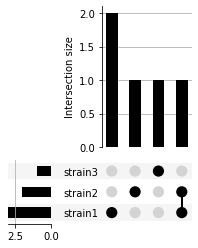

In [13]:
contents = {'strain1': ['pathway_a', 'pathway_b', 'pathway_c'],
            'strain2': ['pathway_b', 'pathway_d'],
            'strain3': ['pathway_e']}
contents = from_contents(contents)

upset = UpSet(contents, subset_size='count')#, intersection_plot_elements=3)
upset.plot()
plt.show()

contents;

### [EXAMPLE] Reformat data to an input for upsetplot
This block below is an implementation test only (arbitrary group comparisons). We can substitute in comparisons of interest.

In [14]:
# glue the species and strain into a separate column
data["Species_Strain_Type_of_Experiment"] = data["Species"] + " " + data["Strain"] + " " + data["Type_of_Experiment"]

# filter out the data of interest
sample_data = data.loc[ : , ['Species_Strain_Type_of_Experiment', 'kegg_pathway_name'] ]

# this is just a test case to test implementation
sample_data.drop_duplicates(inplace=True)
collapse_kegg = lambda x: "|".join(x).split("|")
sample_data = sample_data.groupby(sample_data['Species_Strain_Type_of_Experiment']).aggregate({'kegg_pathway_name':collapse_kegg})

# extract only strain B36:[pathways] to test implementation
sample_data = sample_data.reset_index()
sample_data = sample_data[sample_data["Species_Strain_Type_of_Experiment"].str.contains("B36")]
sample_data = sample_data.set_index("Species_Strain_Type_of_Experiment")

# reformat into UpSetPlot compatible input
sample_data = sample_data.to_dict()['kegg_pathway_name']
sample_data = from_contents(sample_data)
sample_data.head()

id
Escherichia coli B36 Metabolomics GC-MS Escherichia coli B36 Metabolomics LC-MS Escherichia coli B36 RNA-Seq                                           
True                                    True                                    True                                             Fatty acid degradation
                                                                                True                                                Lysine biosynthesis
                                                                                True                                                 Lysine degradation
                                                                                True                          Penicillin and cephalosporin biosynthesis
                                                                                True                                    2-Oxocarboxylic acid metabolism

### [EXAMPLE] Make UpSetPlot

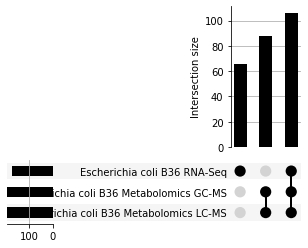

In [15]:
# this is the actual plotting block, the names overlap here but this is fixed in the actual plots
upset = UpSet(sample_data, subset_size='count')#, intersection_plot_elements=3)
upset.plot()
plt.show()

## Filtering data to be visualised <a name="filtering"></a>

Pathways will be selected based on a FDR cutoff of less than 0.05 across all pathways. Then, a barplot displaying the quantity of genes will be generated. There are a few ways we can compare the data, across strain, across omics, with pathways, with genes. 

- [Comparing multi-omics data per strain on pathways](#omics_vs_strain)
- [Comparing strain per multi-omics data on pathways](#strain_vs_omics)

<!---
if you see this line pretend its not here, is a hidden note to self
- [Comparing multi-omics data per strain on genes](#omics_vs_strain_genes)
-->


### *WORK IN PROGRESS* Comparing multi-omics data per strain (pathways) <a name="omics_vs_strain"></a>

For cross-omics comparisons within the strain, we first need to filter out results which have one or less multi-omics comparisons possible after filtering data (eg if we have *Bacteria foo* with only RNA-Seq data available, it is meaningless to include this bacterial strain). Any strains removed due to any applied filters are reported. See also [a comparison of strain per multi-omics data](#strain_vs_omics) where there is one plot per omics data type and many strains (rows).

Below is a comparison of omics data (Metabolomics, Proteomics and Transcriptomics).

Metabolomics as one plot
Proteomics as one plot
RNA-Seq as one plot

Strains dropped from Metabolomics data as they had no KEGG pathway overlap:
                                   0
0      Streptococcus pyogenes PS003
1       Klebsiella pneumoniae AJ218
2        Klebsiella variicola AJ292
3     Staphylococcus aureus BPH2760
4    Streptococcus pneumoniae 180/2
5     Streptococcus pneumoniae 4496
6      Streptococcus pneumoniae 947
7              Escherichia coli B36
8        Klebsiella pneumoniae KPC2
9   Streptococcus pneumoniae 180/15
10    Staphylococcus aureus BPH2900

Strains dropped from Proteomics data as they had no KEGG pathway overlap:
                                   0
0      Streptococcus pyogenes PS003
1          Escherichia coli MS14386
2      Streptococcus pyogenes PS006
3       Streptococcus pyogenes 5448
4          Escherichia coli MS14384
5          Escherichia coli MS14385
6     Streptococcus pneumoniae 4496
7    Streptococcus pneumoniae 180/2
8      Streptococcus p

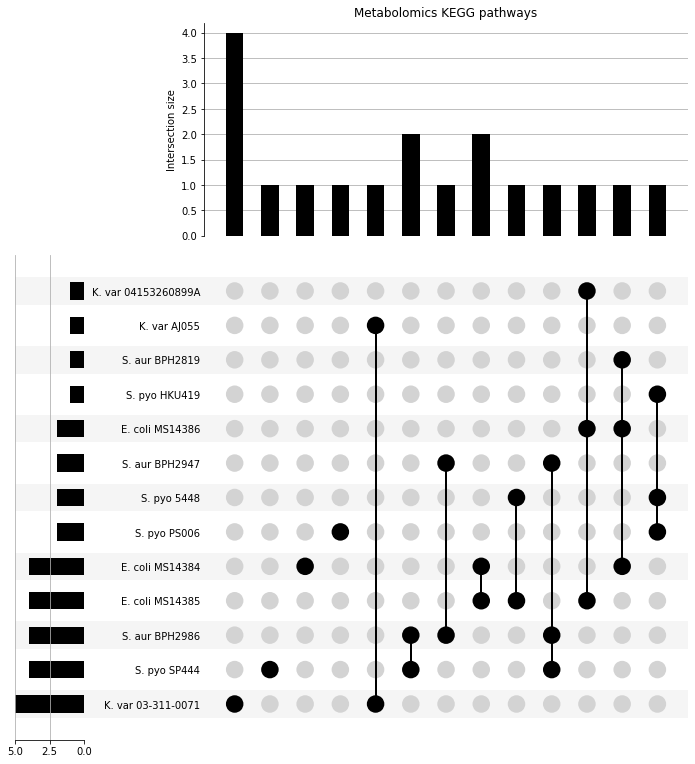

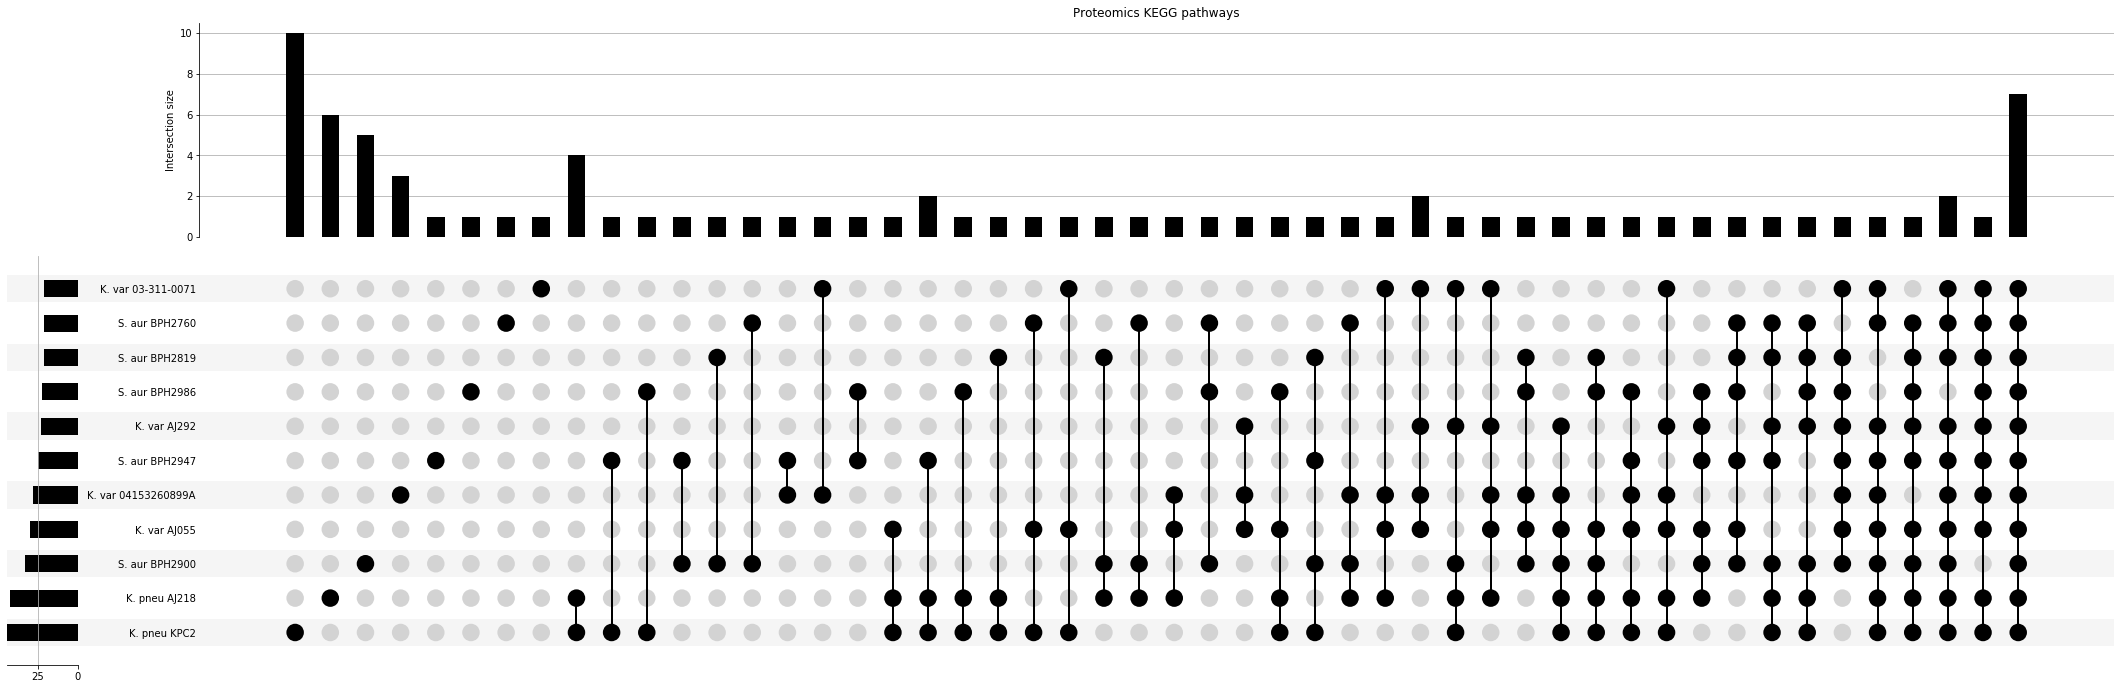

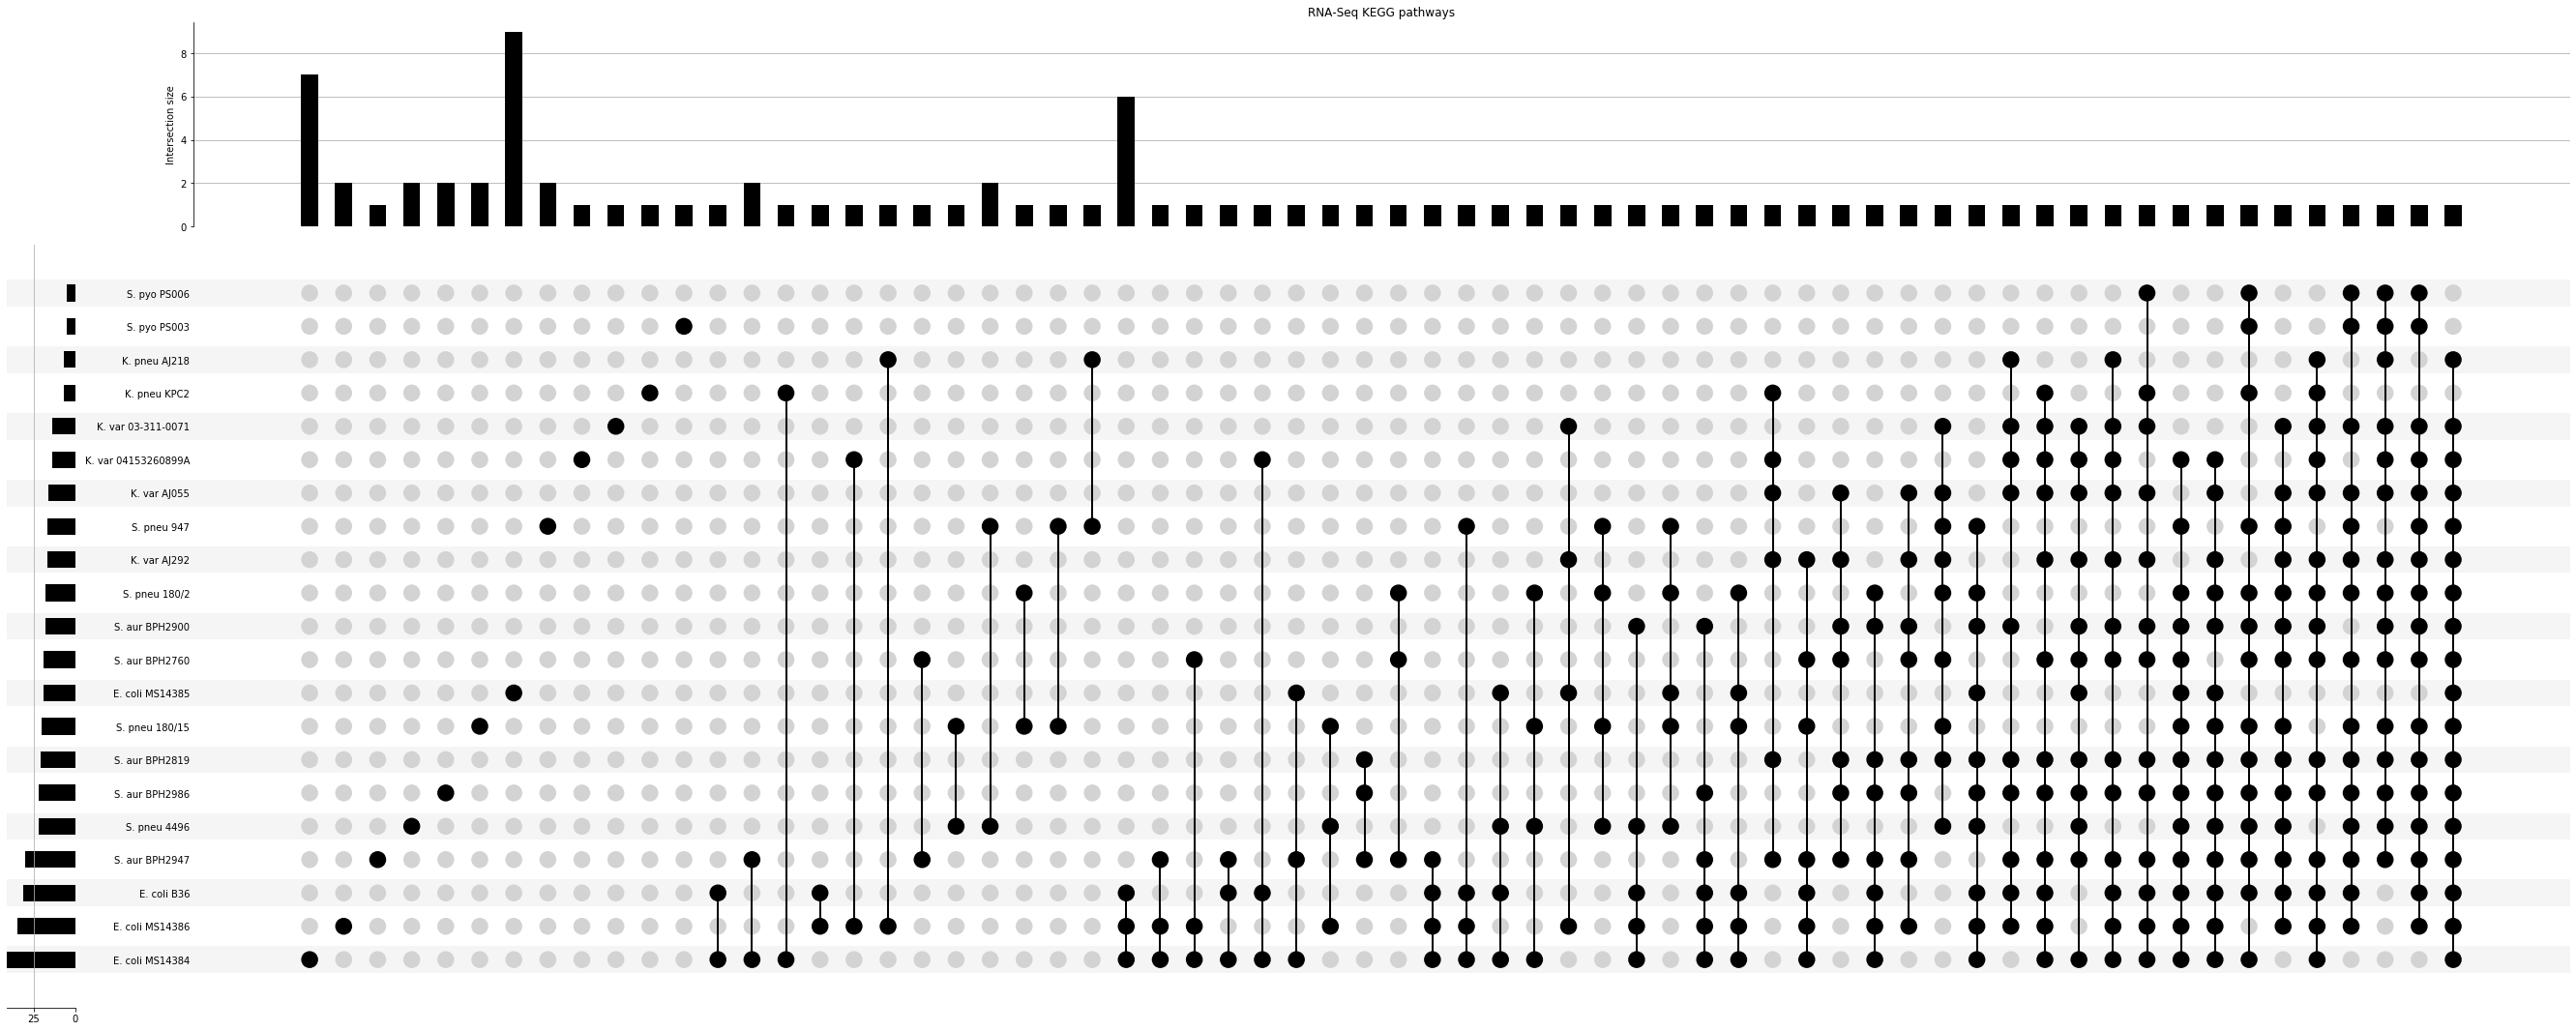

In [16]:
make_upsetplot(reformat_data_for_upsetplot(omics_kegg, "Type_of_Experiment"))

In [17]:
# we saved this data earlier, no need to reload
subset = intermediate_data
print(" ".join(["Data dimensions before", str(filter_unit), str(threshold), "filter:", str(data.shape)]))
print(" ".join(["Data dimensions after", str(filter_unit), str(threshold), "filter: ", str(subset.shape)]))
print(" ".join(["Strains removed by", str(filter_unit), str(threshold), "filter:", removed]))

# filter out the categories of interest
omics_kegg = subset.loc[ : , ['Species_Strain', 'Species_Strain_Type_of_Experiment', 'kegg_pathway_name', 'Species', 'Strain', 'Type_of_Experiment'] ]
omics_kegg.drop_duplicates(inplace=True)

# we want one plot per omics type
omics = omics_kegg['Type_of_Experiment'].unique()
omics.sort()
[print(omic, "as one plot") for omic in omics]

omics_kegg = [omics_kegg[omics_kegg["Species_Strain_Type_of_Experiment"].str.contains(omic)] for omic in omics]
collapse_kegg = lambda x: "|".join(x).split("|")
omics_kegg = [omic_kegg.groupby(omic_kegg['Species_Strain']).aggregate({'kegg_pathway_name':collapse_kegg}) for omic_kegg in omics_kegg]

# display non-overlapping strains
sp_strains = data["Species"] + " " + data["Strain"]
sp_strains_unique = sp_strains.unique()
sp_strains_unique.sort()
dropped_strains = [list(x) for x in [set(sp_strains_unique) - set(index) for index in [omic.index for omic in omics_kegg]]]
dropped_strains = list(zip(omics, dropped_strains))
[print("\nStrains dropped from", omic, "data as they had no KEGG pathway overlap:\n", pandas.DataFrame(strain)) for omic, strain in dropped_strains]

omics_kegg = list(zip(omics, omics_kegg))

Data dimensions before FDR 0.05 filter: (31812, 19)
Data dimensions after FDR 0.05 filter:  (974, 19)
Strains removed by FDR 0.05 filter: {'Escherichia coli MS14387'}
Metabolomics GC-MS as one plot
Metabolomics LC-MS as one plot
Proteomics MS1 DDA as one plot
Proteomics MS2 DIA/SWATH as one plot
RNA-Seq as one plot

Strains dropped from Metabolomics GC-MS data as they had no KEGG pathway overlap:
                                   0
0      Streptococcus pyogenes PS003
1       Klebsiella pneumoniae AJ218
2      Streptococcus pyogenes PS006
3       Streptococcus pyogenes 5448
4        Klebsiella variicola AJ292
5     Staphylococcus aureus BPH2986
6     Staphylococcus aureus BPH2760
7     Streptococcus pneumoniae 4496
8    Streptococcus pneumoniae 180/2
9          Escherichia coli MS14387
10     Streptococcus pneumoniae 947
11    Staphylococcus aureus BPH2947
12    Streptococcus pyogenes HKU419
13             Escherichia coli B36
14       Klebsiella pneumoniae KPC2
15  Streptococcus pneum

Below is a comparison of assay data (GC-MS, LC-MS, etc Transcriptomics). In this case each assay is treated as independent, ie GC-MS and LC-MS are kept separate although they are both proteomics to review any instrument effects.



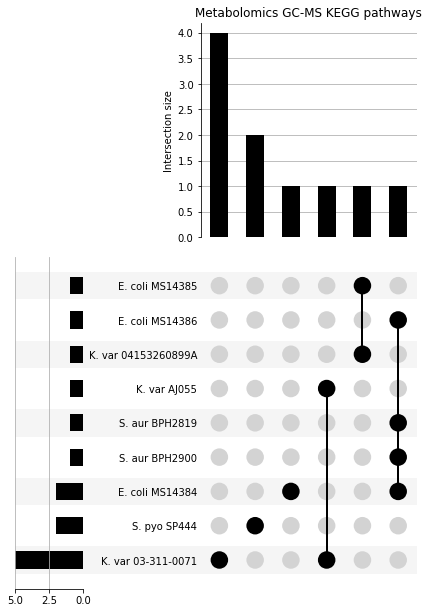

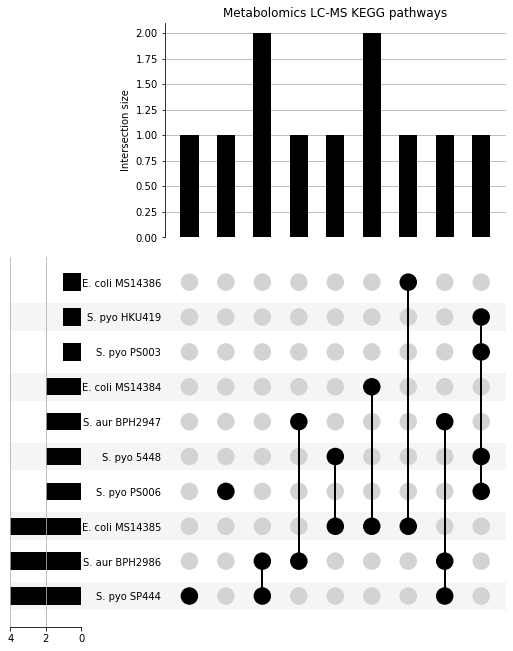

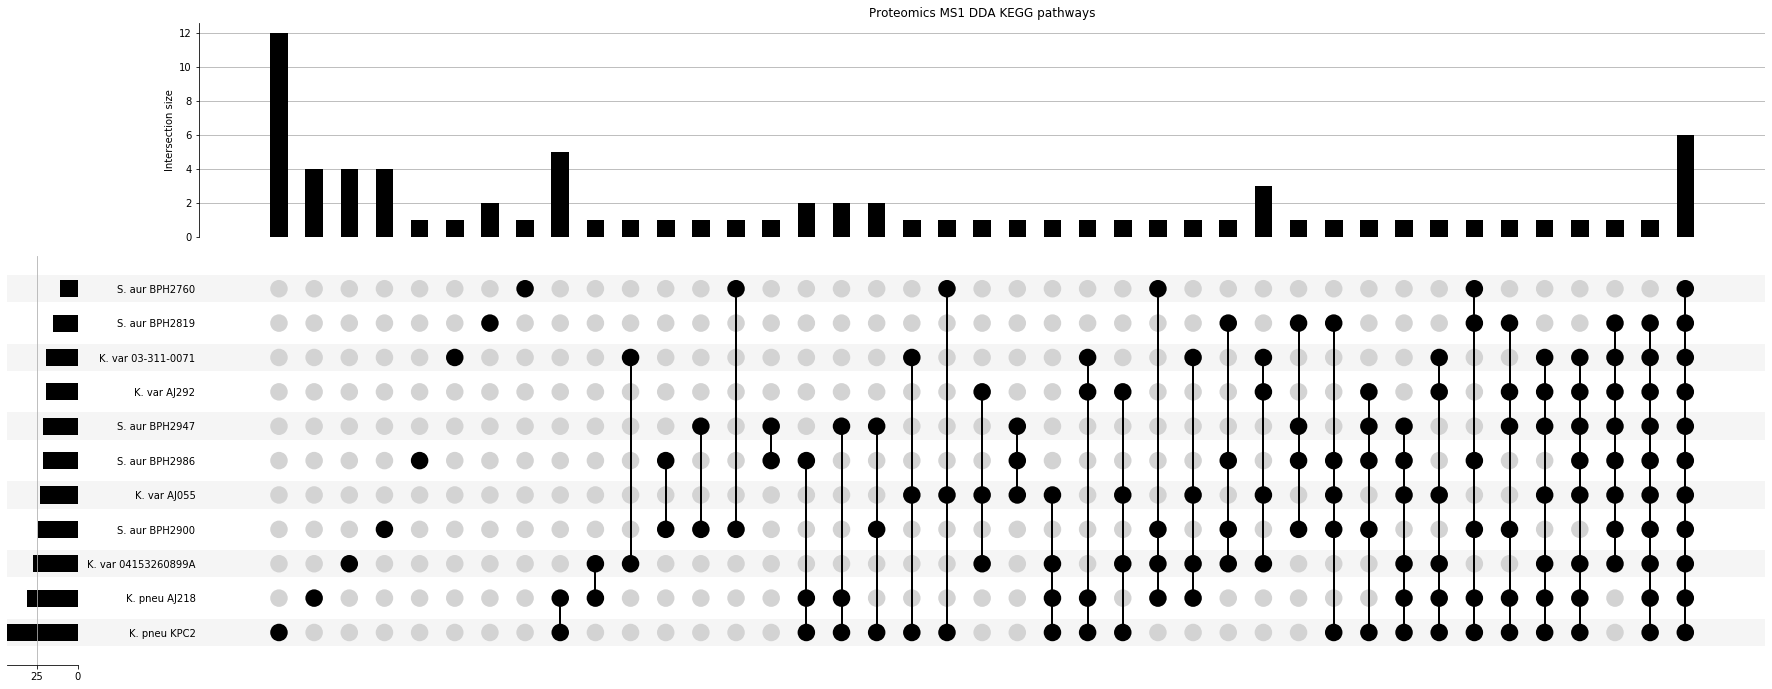

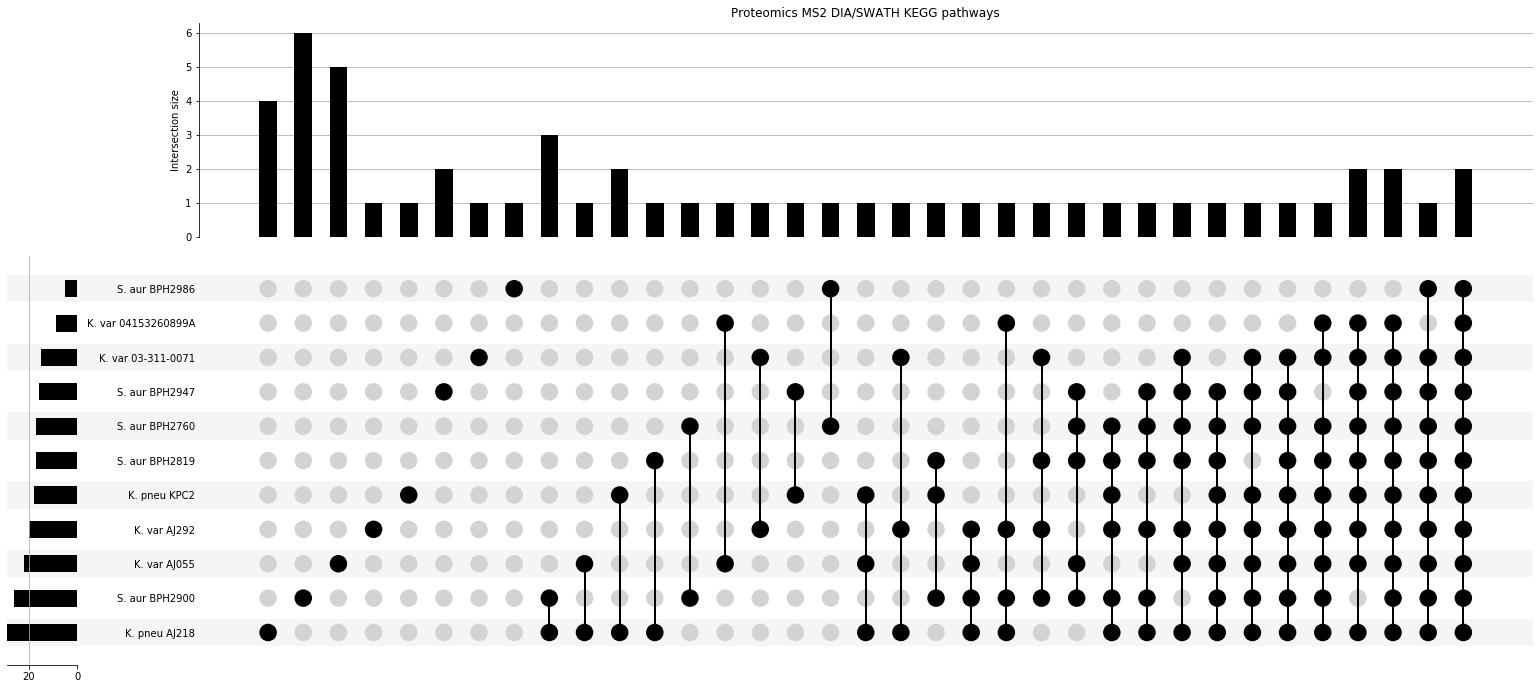

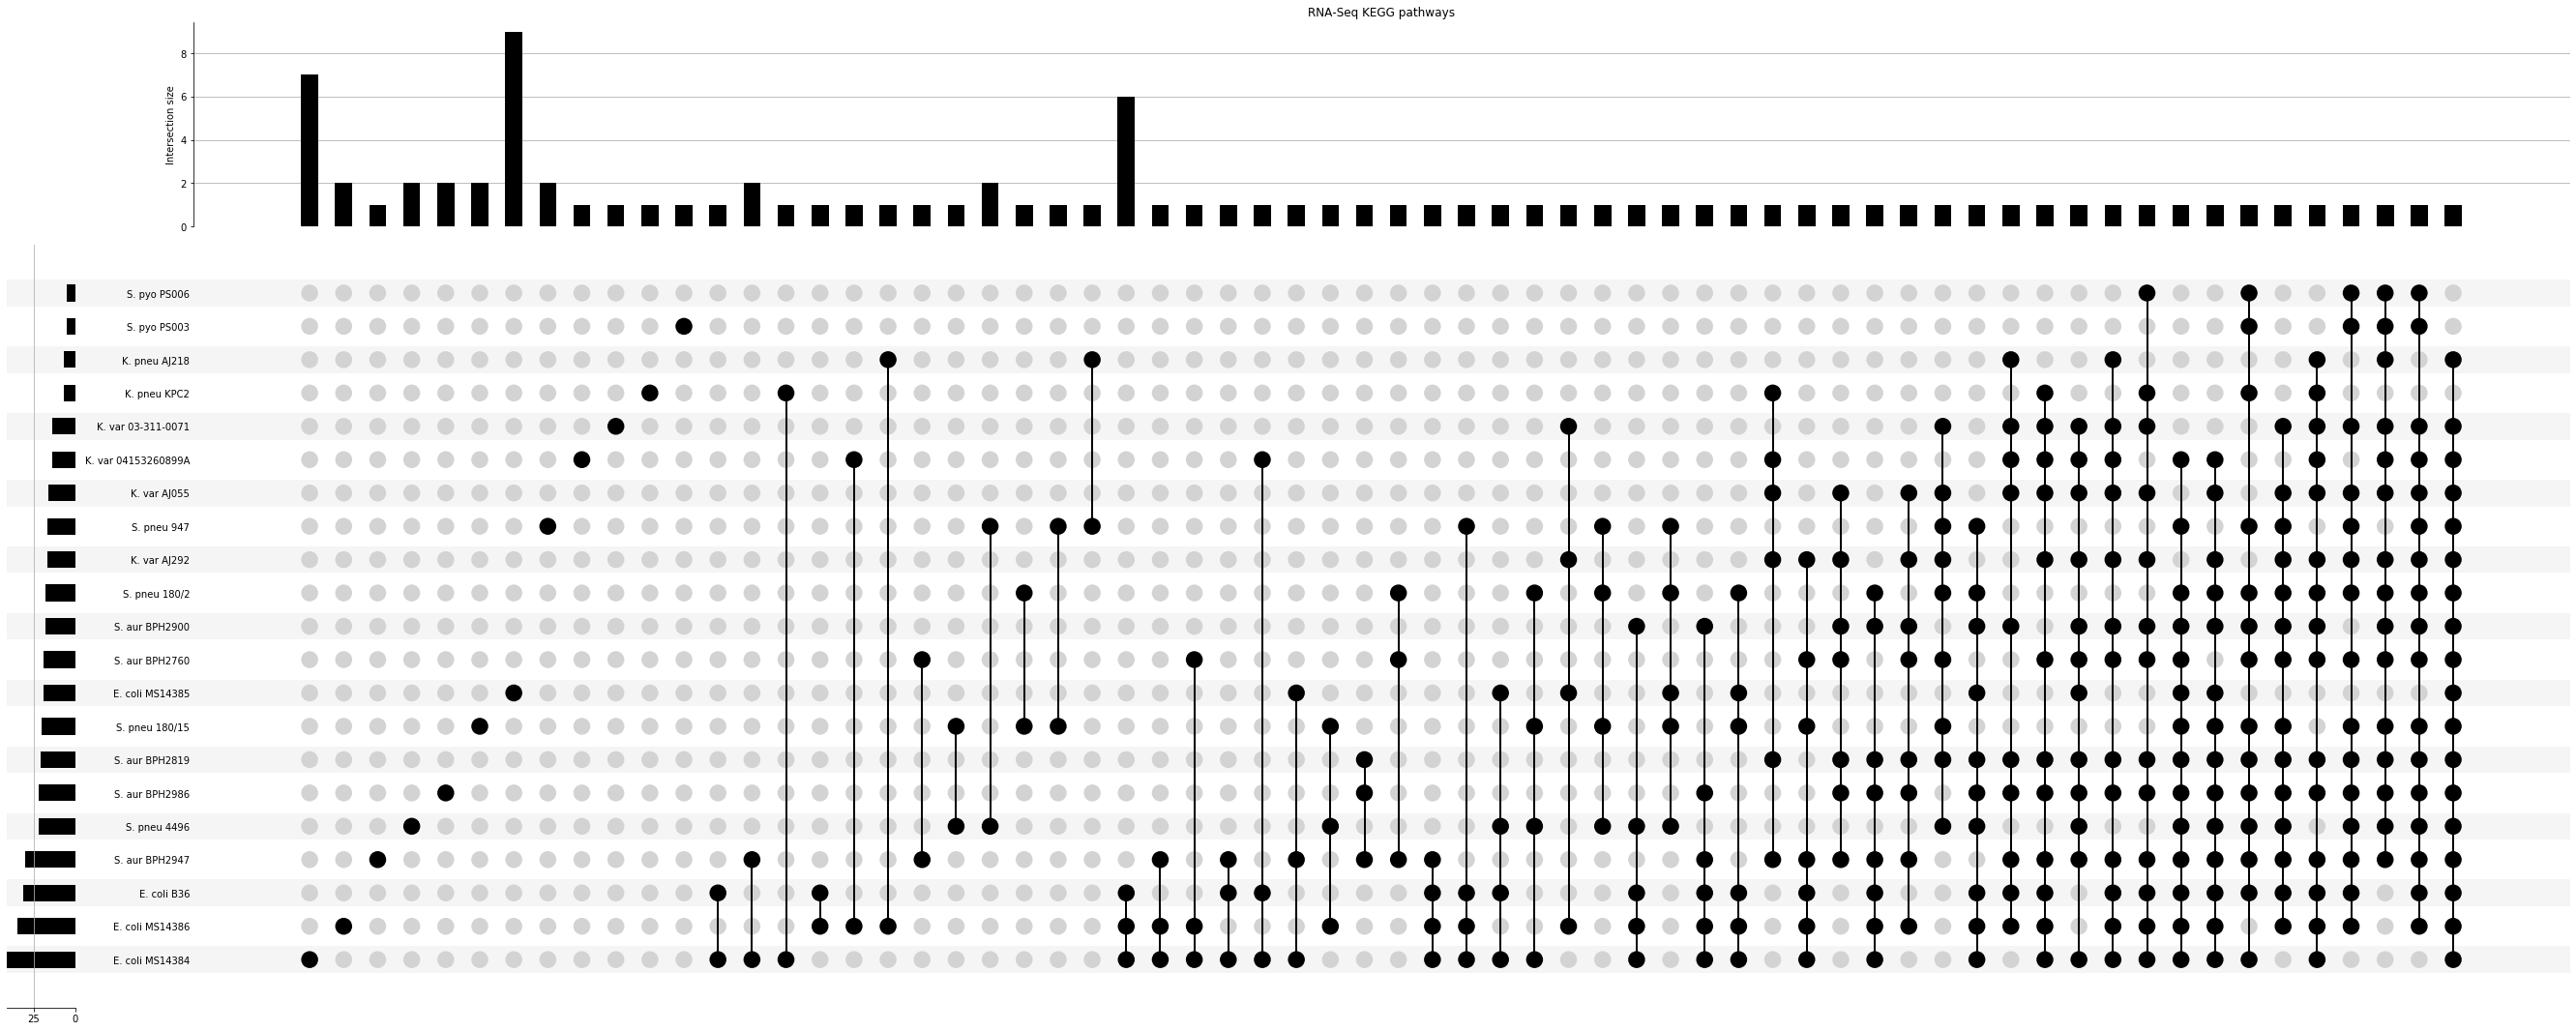

In [18]:
make_upsetplot(omics_kegg)

Now we look at how each omics data type intersects across different strains.

In [19]:
# filter out the categories of interest
omics_kegg = subset.loc[ : , ['Species_Strain_Type_of_Experiment', 'Species_Strain_Type_of_Experiment_Direction', 'kegg_pathway_name', 'Species', 'Strain', 'Type_of_Experiment'] ]
omics_kegg.drop_duplicates(inplace=True)
collapse_kegg = lambda x: "|".join(x).split("|")
omics_kegg = omics_kegg.groupby(omics_kegg['Species_Strain_Type_of_Experiment']).aggregate({'kegg_pathway_name':collapse_kegg})

# if comparing across omics, filter out single-omics entries
sp_strains = data["Species"] + " " + data["Strain"]
sp_strains_unique = sp_strains.unique()
sp_strains_unique.sort()
omics_kegg = omics_kegg.reset_index()
sp_strains = [omics_kegg[omics_kegg["Species_Strain_Type_of_Experiment"].str.contains(sp_strain)] for sp_strain in sp_strains_unique]

filtered = [sp_strain["Species_Strain_Type_of_Experiment"].unique() for sp_strain in sp_strains]
filtered = [x for y in filtered for x in y]
filtered = numpy.array(list(set([" ".join(x.split(" ", 3)[:3]) for x in filtered])))
filtered.sort()

strain_singleomics = list()
strain_multiomics = list()

for sp_strain in sp_strains:
    if len(sp_strain) > 1:
        sp_strain.set_index("Species_Strain_Type_of_Experiment", inplace=True)
        strain_multiomics.append(sp_strain)
    else:
        sp_strain.set_index("Species_Strain_Type_of_Experiment", inplace=True)
        strain_singleomics.append(sp_strain)

strain_singleomics = [x.reset_index()["Species_Strain_Type_of_Experiment"].tolist() for x in strain_singleomics]
strain_singleomics = [x for y in strain_singleomics for x in y]
strain_singleomics = [" ".join(x.split(" ", 3)[:3]) for x in strain_singleomics]
print("No multi-omic comparison available for strain(s):\n", pandas.DataFrame(strain_singleomics))

#strain_multiomics

No multi-omic comparison available for strain(s):
                                  0
0             Escherichia coli B36
1  Streptococcus pneumoniae 180/15
2   Streptococcus pneumoniae 180/2
3    Streptococcus pneumoniae 4496
4     Streptococcus pneumoniae 947
5      Streptococcus pyogenes 5448
6    Streptococcus pyogenes HKU419


Note that figure legends below are shortened as they overlap with figure elements. "M" replaces instances of "Metabolomics" and "P" replaces instances of "Proteomics".

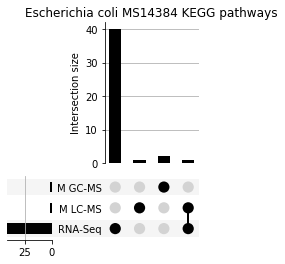

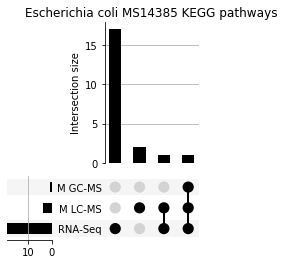

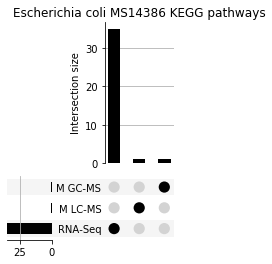

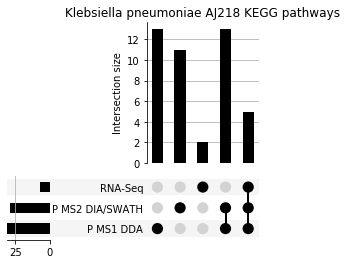

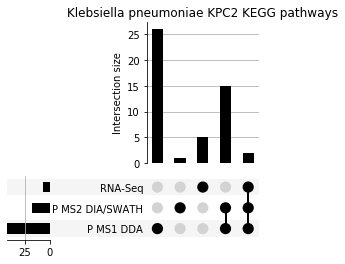

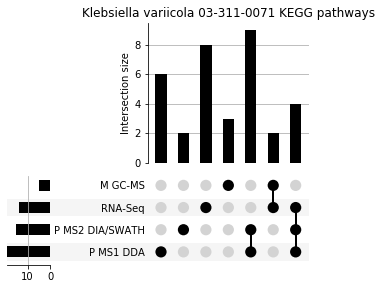

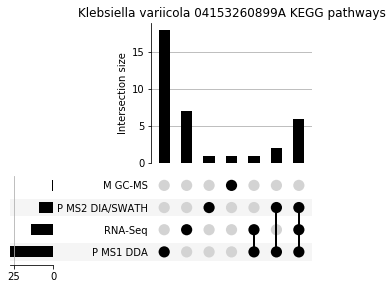

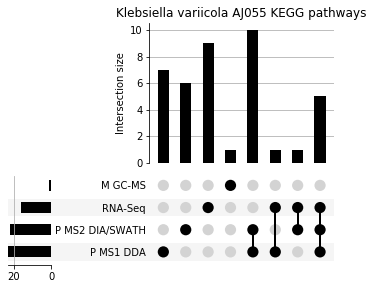

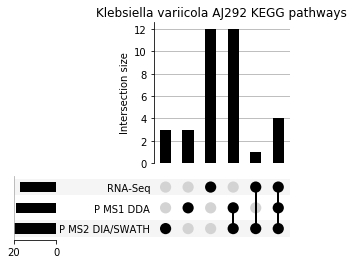

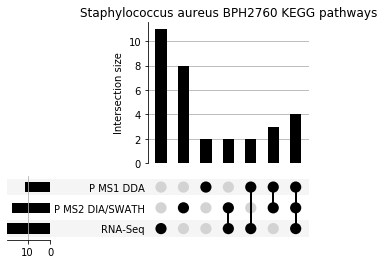

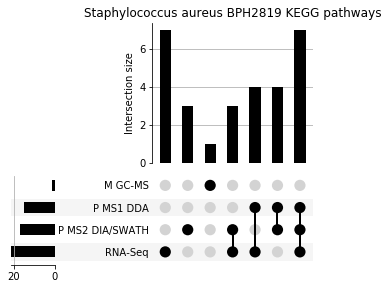

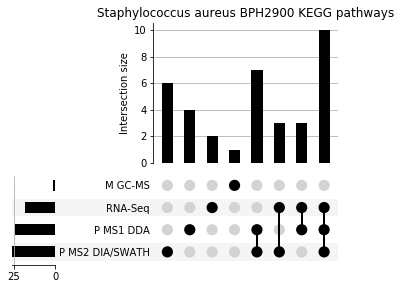

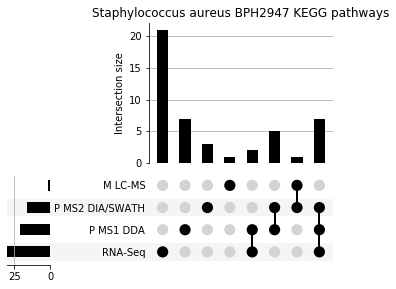

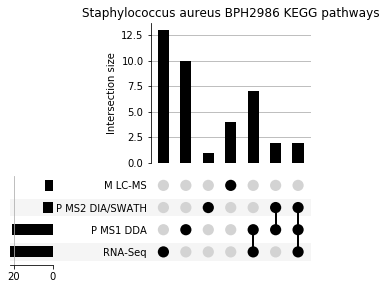

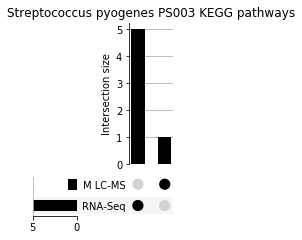

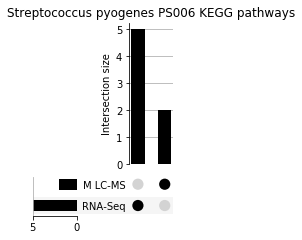

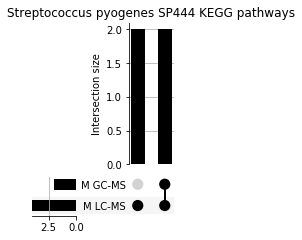

In [20]:
# the plotting block
for strain_multiomic in strain_multiomics:
    # legends too long and run off page, shorten
    strain_multiomic.reset_index(inplace=True)
    old_index = strain_multiomic["Species_Strain_Type_of_Experiment"]
    plt_title = [" ".join(x.split(" ", 3)[:3]) for x in old_index.tolist()]
    assert len(set(plt_title)) is 1, "There seems to be more than one species present within one comparison"
    new_index = [" ".join(x.split(" ", 3)[3:]) for x in old_index.tolist()]
    new_index = [omic.replace("Metabolomics", "M") for omic in new_index]
    new_index = [omic.replace("Proteomics", "P") for omic in new_index]
    strain_multiomic["Species_Strain_Type_of_Experiment"] = new_index
    strain_multiomic.set_index("Species_Strain_Type_of_Experiment", inplace=True)
    
    # removes pathways duplicated within a single strain
    strain_multiomic["kegg_pathway_name"] = strain_multiomic["kegg_pathway_name"].apply(set).apply(list).apply(sorted)
    strain_multiomic = strain_multiomic.to_dict()["kegg_pathway_name"]
    strain_multiomic = from_contents(strain_multiomic)
    upset = UpSet(strain_multiomic, subset_size='count')#, intersection_plot_elements=3)
    upset.plot()
    plt.title(" ".join([plt_title[0], "KEGG pathways"]))
    plt.show()


<!---
### *TODO* Comparing multi-omics data per strain (genes) <a name="omics_vs_strain_genes"></a>
--->